In [1]:
import yaml
import torch
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch_geometric.loader import DataLoader

from models.GCN import GCN
from models.GAT import GATFLAT, GATFLAT_MC_DROPOUT

from help_funcs.data_func import load_dataset
from help_funcs.param import get_loss_function

# Functions

In [2]:
def make_interference(data, model, loss_name, loss_func, batch_size):
    val_loss = 0
    all_predictions = []
    all_labels = []
    y_score = []
    
    for batch in data:
        x, edge_index, edge_weight, structure = batch.x, batch.edge_index, batch.edge_attr, batch.batch
        y_hat = model.forward(x, edge_index, edge_weight, structure)
        
        if loss_name != 'BCE':
            y_score += y_hat.exp().tolist()
        else:
            y_score += y_hat.tolist()

        y = batch.y
        if loss_name == 'BCE':
            y = y.float()
            y_hat = y_hat.squeeze(1)
        y = y

        loss = loss_func(y_hat, y)

        val_loss += (loss)*(len(batch)/batch_size)


        if loss_name == 'BCE':
            all_predictions += y_hat.round().tolist()
        else:
            all_predictions += torch.argmax(y_hat, dim=-1).tolist()
        all_labels += batch.y.tolist()

    if loss_name != 'BCE':
        class_labels = {0:'TD', 1:'ASD-ADHD', 2:'ASD', 3:'ADHD'}
    else: 
        class_labels = {0:'TD', 1:'Non-TD'}

    softmax_data = pd.DataFrame()
    softmax_data['label'] = all_labels
    softmax_data['label'] = softmax_data['label'].replace(class_labels)
    softmax_data['predicted'] = all_predictions
    softmax_data['predicted'] = softmax_data['predicted'].replace(class_labels)
    softmax_data['softmax_values'] = y_score
    
    if len(class_labels) != 2:
        for key, value in class_labels.items():
                softmax_data[value] = softmax_data['softmax_values'].apply(lambda x: x[key])

    return val_loss/len(data), f1_score(all_labels, all_predictions, average='micro'), y_score, all_labels, softmax_data

In [3]:
def plot_ruc(roc_curve_data, num_of_classes):
    # Define class labels and split names
    split_names = ['train', 'val', 'test']
    colors = {0:'red', 1:'green', 2:'orange', 3:'blue'}

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
    if num_of_classes == 4:
        class_labels_legends = {0:'TD', 1:'ASD-ADHD', 2:'ASD', 3:'ADHD'}
    else: 
        class_labels_legends = {0:'TD', 1:'Non-TD'}

    for ax, split_name in zip(axes, split_names):
        y_true = np.array(roc_curve_data[split_name][0])
        y_probs = np.array(roc_curve_data[split_name][1])
        
        y_true_bin = label_binarize(y_true, classes=np.arange(num_of_classes))
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(num_of_classes if num_of_classes != 2 else 1):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            ax.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                    label=f'{class_labels_legends[i]} (AUC = {roc_auc[i]:.2f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{split_name.capitalize()} ROC Curve')
        ax.legend(loc='lower right')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

In [4]:
def evaluate_model(yaml_file:str, model_file:str, drop_strategy:int = None, gat:bool = False):
    with open(yaml_file, 'r') as file:
        parameters = yaml.safe_load(file)

    #align parameters
    if parameters.get('feature_names', None) == None:
        parameters['feature_names'] = parameters['feature_set']
    
    if parameters.get('edge_names', None) == None:
        parameters['edge_names'] = parameters['edge_feature_set']
    
    if parameters.get('edge_w_thres', None) == None:
        parameters['edge_w_thres'] = {'value': None} 
    
    if parameters.get('edge_w_abs', None) == None:
        parameters['edge_w_abs'] = {'value': False}

    if parameters.get('relative_edge_thres', None) == None:
        parameters['relative_edge_thres'] = {'value': None}
    
    if parameters.get('loss_name', None) == None:
        parameters['loss_name']= parameters['loss_func']


    train_data = load_dataset(dataset = 'train', 
                            num_of_classes = parameters['num_of_classes']['value'],
                            feature_names = parameters['feature_names']['value'],
                            edge_names = parameters['edge_names']['value'],
                            edge_w_thres = parameters['edge_w_thres']['value'],
                            drop_strategy = drop_strategy,
                            edge_w_abs = parameters['edge_w_abs']['value'],
                            edge_w_relative = parameters['edge_weight_thres']['value'] if parameters['relative_edge_thres']['value'] else None,
                            GAT = gat
                                )

    val_data = load_dataset(dataset = 'val', 
                            num_of_classes = parameters['num_of_classes']['value'],
                            feature_names = parameters['feature_names']['value'],
                            edge_names = parameters['edge_names']['value'],
                            edge_w_thres = parameters['edge_w_thres']['value'],
                            drop_strategy = drop_strategy,
                            edge_w_abs = parameters['edge_w_abs']['value'],
                            edge_w_relative = parameters['edge_weight_thres']['value'] if parameters['relative_edge_thres']['value'] else None,
                            GAT = gat
                                    )

    test_data = load_dataset(dataset = 'test', 
                            num_of_classes = parameters['num_of_classes']['value'],
                            feature_names = parameters['feature_names']['value'],
                            edge_names = parameters['edge_names']['value'],
                            edge_w_thres = parameters['edge_w_thres']['value'],
                            drop_strategy = drop_strategy,
                            edge_w_abs = parameters['edge_w_abs']['value'],
                            edge_w_relative = parameters['edge_weight_thres']['value'] if parameters['relative_edge_thres']['value'] else None,
                            GAT = gat
                                    )

    train_loader = DataLoader(train_data, 
                            batch_size=parameters['batch_size']['value'])
                                
    val_loader = DataLoader(val_data, 
                            batch_size=parameters['batch_size']['value'])

    test_loader = DataLoader(test_data, 
                            batch_size=parameters['batch_size']['value'])
    
    if parameters['num_of_classes']['value'] == 2:
        num_of_classes = 1
    else:
        num_of_classes = parameters['num_of_classes']['value']

    if gat:
        model = GATFLAT(in_ = parameters['num_of_features']['value'], 
                        out_ = num_of_classes, 
                        layer_1_out = parameters['hidden_channels_1']['value'], 
                        dropout_rate = parameters['dropout']['value'], 
                        activation_ = parameters['activation']['value'], 
                        heads_ = parameters['att_heads']['value'], 
                        norm_ = parameters['layer_norm']['value'], 
                        out_func_ = parameters['loss_name']['value'], 
                        random_seed = parameters['random_seed']['value'])
    else:
        model = GCN(in_ = parameters['num_of_features']['value'], 
                        out_ = num_of_classes, 
                        layer_1_out = parameters['hidden_channels_1']['value'], 
                        dropout_rate = parameters['dropout']['value'], 
                        activation_ = parameters['activation']['value'], 
                        pool_ = parameters['pool']['value'], 
                        norm_ = parameters['layer_norm']['value'], 
                        out_func_ = parameters['loss_name']['value'], 
                        random_seed = parameters['random_seed']['value'])

    model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))
    model.eval()

    loss_func = get_loss_function(parameters['loss_name']['value'])

    roc_curve_data = {}
    train_softmax_data = None
    for n, d in [('train', train_loader),('val', val_loader), ('test', test_loader)]:
        l, f1, y_score, y, softmax_data = make_interference(data = d,
                                                model = model, 
                                                loss_name = parameters['loss_name']['value'], 
                                                loss_func = loss_func,
                                                batch_size = parameters['batch_size']['value'])
        print(f"{n} loss: {l} f1:{f1}")
        roc_curve_data[n] = [y, y_score]
        if n == 'train':
            train_softmax_data = softmax_data

    plot_ruc(roc_curve_data, num_of_classes = parameters['num_of_classes']['value'])
    return train_softmax_data

In [32]:
def epistemic(yaml_file:str, model_file:str, diagnosis:str, dropout:float, 
              forward_passes:int, drop_strategy:int = None, gat:bool = False):

    with open(yaml_file, 'r') as file:
            parameters = yaml.safe_load(file)
    
    #align parameters
    if parameters.get('feature_names', None) == None:
        parameters['feature_names'] = parameters['feature_set']
    
    if parameters.get('edge_names', None) == None:
        parameters['edge_names'] = parameters['edge_feature_set']
    
    if parameters.get('edge_w_thres', None) == None:
        parameters['edge_w_thres'] = {'value': None} 
    
    if parameters.get('edge_w_abs', None) == None:
        parameters['edge_w_abs'] = {'value': False}

    if parameters.get('relative_edge_thres', None) == None:
        parameters['relative_edge_thres'] = {'value': None}
    
    if parameters.get('loss_name', None) == None:
        parameters['loss_name']= parameters['loss_func']

    data = load_dataset(dataset = f'train_{diagnosis.lower()}_uncertainty', 
                        num_of_classes = parameters['num_of_classes']['value'],
                        feature_names = parameters['feature_names']['value'],
                        edge_names = parameters['edge_names']['value'],
                        edge_w_thres = parameters['edge_w_thres']['value'],
                        drop_strategy = drop_strategy,
                        edge_w_abs = parameters['edge_w_abs']['value'],
                        edge_w_relative = parameters['edge_weight_thres']['value'] if parameters['relative_edge_thres']['value'] else None,
                        GAT = gat
                                )
    
    data = DataLoader(data, batch_size=1)

    if parameters['num_of_classes']['value'] == 2:
        num_of_classes = 1
    else:
        num_of_classes = parameters['num_of_classes']['value']
    
    if num_of_classes == 4:
        class_labels_legends = {0:'TD', 1:'ASD-ADHD', 2:'ASD', 3:'ADHD'}
        class_index = {'TD': 0, 'ASDADHD':1, 'ASD':2, 'ADHD':3}
    else: 
        class_labels_legends = {0:'TD', 1:'Non-TD'}
        class_index = {'TD':0, 'Non-TD':1}

    model = GATFLAT_MC_DROPOUT(in_ = parameters['num_of_features']['value'], 
                        out_ = num_of_classes, 
                        layer_1_out = parameters['hidden_channels_1']['value'], 
                        dropout_rate = dropout, 
                        activation_ = parameters['activation']['value'], 
                        heads_ = parameters['att_heads']['value'], 
                        norm_ = parameters['layer_norm']['value'], 
                        out_func_ = parameters['loss_name']['value'], 
                        random_seed = parameters['random_seed']['value'])
    
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))

    outputs = []
    labels = []

    for f in range(forward_passes):
        for batch in data:
            x, edge_index, edge_weight, node_index = batch.x, batch.edge_index, batch.edge_attr, batch.batch
            #batch = batch.to(device, non_blocking=True)
            out = model.forward(x, edge_index, edge_weight, node_index) 
            outputs.append(out.unsqueeze(0))

            if parameters['loss_name']['value'] == 'BCE':
                pre_ = out.round().tolist()[0][0]
                labels.append(class_labels_legends[pre_])
            else:
                pre_ = torch.argmax(out, dim=-1).tolist()[0]
                labels.append(class_labels_legends[pre_])
            
    
    outputs = torch.cat(outputs, dim=0)
    if parameters['loss_name']['value'] != 'BCE':
        #Log softmax -> softmax
        outputs = outputs.exp()

    mean_output = outputs.mean(dim=0)
    variance_output = outputs.var(dim=0)
    print("Predicted labels count:", dict(Counter(labels)))
    print(f"Mean: {mean_output.tolist()[0][class_index[diagnosis]]}")
    print(f"Variance: {variance_output.tolist()[0][class_index[diagnosis]]}")

# GCN Multi-class

train loss: 0.9816800355911255 f1:0.5782312925170068
val loss: 0.97920161485672 f1:0.4444444444444444
test loss: 1.2514183521270752 f1:0.42857142857142855


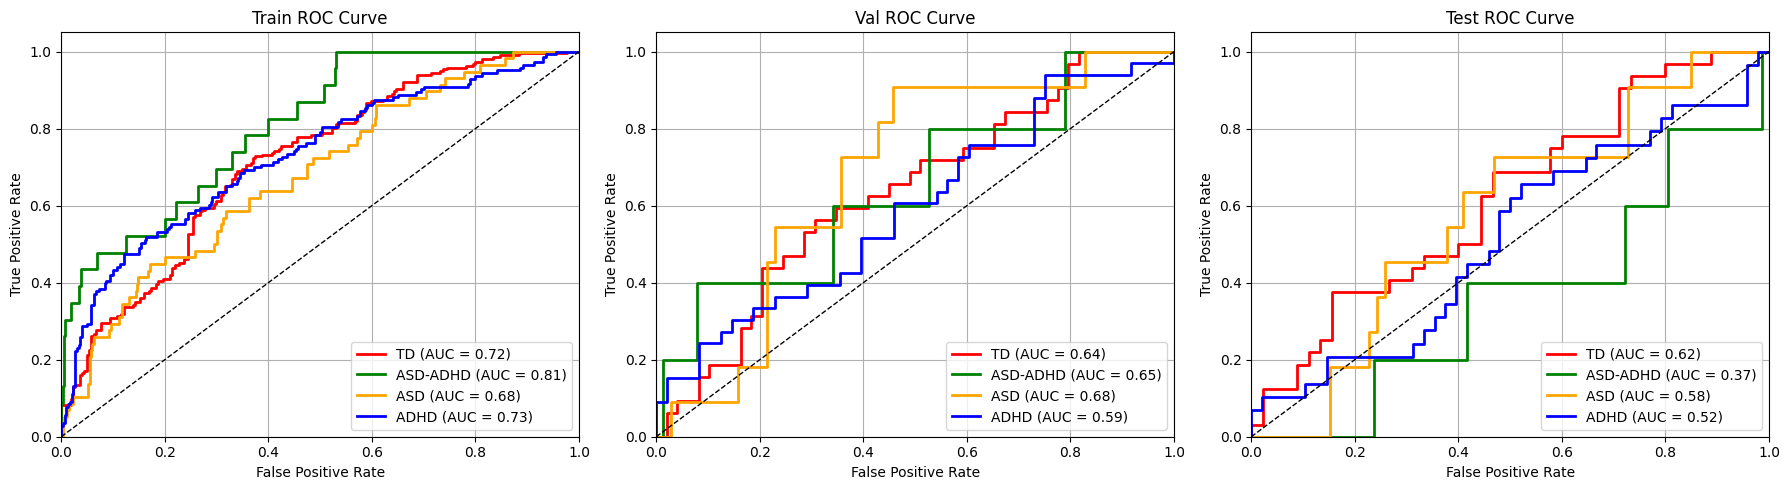

,label,predicted,softmax_values,TD,ASD-ADHD,ASD,ADHD
0,TD,ADHD,"[0.4096071720123291, 0.048506952822208405, 0.1...",0.409607,0.048507,0.127005,0.414881
1,TD,ADHD,"[0.4831802546977997, 0.0031310198828577995, 0....",0.483180,0.003131,0.008912,0.504777
2,TD,TD,"[0.5247132182121277, 0.0929989218711853, 0.121...",0.524713,0.092999,0.121195,0.261093
3,ADHD,ADHD,"[0.4566940367221832, 0.014801044948399067, 0.0...",0.456694,0.014801,0.018657,0.509848
4,ADHD,ADHD,"[0.24862021207809448, 0.06553246080875397, 0.1...",0.248620,0.065532,0.112770,0.573078
...,...,...,...,...,...,...,...
436,ADHD,TD,"[0.5504769682884216, 0.06569887697696686, 0.08...",0.550477,0.065699,0.081083,0.302741
437,ADHD,ADHD,"[0.24371486902236938, 0.04314572364091873, 0.0...",0.243715,0.043146,0.068454,0.644685
438,TD,TD,"[0.6350549459457397, 0.03166240453720093, 0.12...",0.635055,0.031662,0.123493,0.209790
439,TD,TD,"[0.4717538356781006, 0.10150475800037384, 0.08...",0.471754,0.101505,0.089786,0.336955


In [6]:
evaluate_model(yaml_file = "saved_models/GCN_Multi_absolute_weights.yaml", 
               model_file = "saved_models/GCN_Multi_absolute_weights.pt", 
               drop_strategy = None, 
               gat = False)

# GCN Binary-class

train loss: 0.5547943711280823 f1:0.6938775510204082
val loss: 0.5222151875495911 f1:0.654320987654321
test loss: 0.5780280828475952 f1:0.6103896103896104


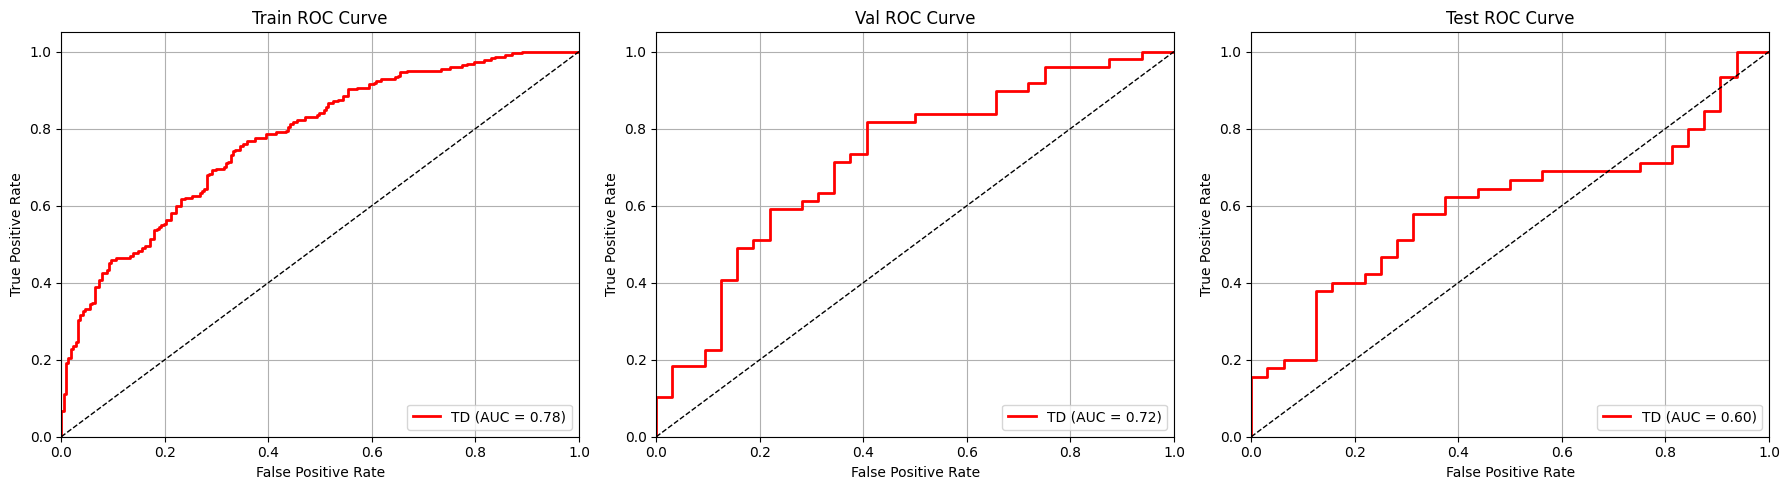

,label,predicted,softmax_values
0,TD,Non-TD,[0.5472467541694641]
1,TD,TD,[0.47332605719566345]
2,TD,Non-TD,[0.6302391290664673]
3,Non-TD,Non-TD,[0.5881670713424683]
4,Non-TD,Non-TD,[0.7684990167617798]
...,...,...,...
436,Non-TD,Non-TD,[0.500506579875946]
437,Non-TD,Non-TD,[0.7893200516700745]
438,TD,TD,[0.46997135877609253]
439,TD,TD,[0.29943713545799255]


In [7]:
evaluate_model(yaml_file = "saved_models/GCN_Binary_absolute_weights.yaml", 
               model_file = "saved_models/GCN_Binary_absolute_weights.pt", 
               drop_strategy = None, 
               gat = False)

# GAT Multi-class

train loss: 0.8160123825073242 f1:0.6621315192743764
val loss: 0.9097995162010193 f1:0.5679012345679012
test loss: 1.3263483047485352 f1:0.37662337662337664


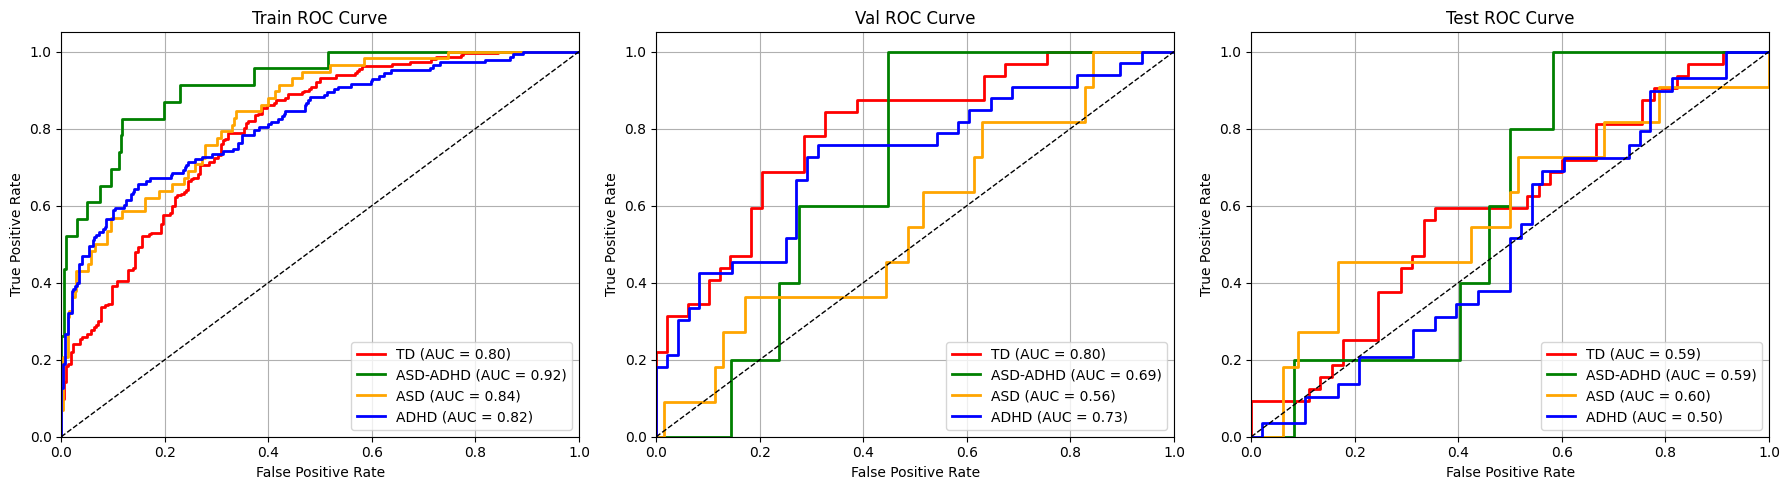

In [8]:
softmax_data = evaluate_model(yaml_file = "saved_models/GAT_Multi_S2_relative.yaml", 
                            model_file = "saved_models/GAT_Multi_S2_relative.pt", 
                            drop_strategy = 2, 
                            gat = True)

In [9]:
means = softmax_data[['label', 'predicted', 'TD', 'ASD-ADHD', 'ASD', 'ADHD']].groupby(['label', 'predicted']).mean().reset_index()
means['count'] = softmax_data[['label', 'predicted', 'TD']].groupby(['label', 'predicted']).count().reset_index()['TD']

In [41]:
for d in ['TD', 'ADHD', 'ASD', 'ASDADHD']:
    print(f"************ {d} ************")
    epistemic(yaml_file = "saved_models/GAT_Multi_S2_relative.yaml", 
            model_file = "saved_models/GAT_Multi_S2_relative.pt", 
            diagnosis = d,
            dropout = 0.25, 
            forward_passes = 100,
            drop_strategy = 2, 
            gat = True)

************ TD ************
Predicted labels count: {'TD': 86, 'ADHD': 14}
Mean: 0.49018970131874084
Variance: 0.007890742272138596
************ ADHD ************
Predicted labels count: {'ADHD': 88, 'TD': 12}
Mean: 0.5319413542747498
Variance: 0.00981061439961195
************ ASD ************
Predicted labels count: {'TD': 96, 'ASD': 2, 'ADHD': 2}
Mean: 0.22642509639263153
Variance: 0.0035897279158234596
************ ASDADHD ************
Predicted labels count: {'TD': 75, 'ADHD': 8, 'ASD-ADHD': 17}
Mean: 0.2540329694747925
Variance: 0.011275961063802242


# GAT Binary

train loss: 0.4492197036743164 f1:0.7437641723356009
val loss: 0.3664683401584625 f1:0.7407407407407407
test loss: 0.7494200468063354 f1:0.6103896103896104


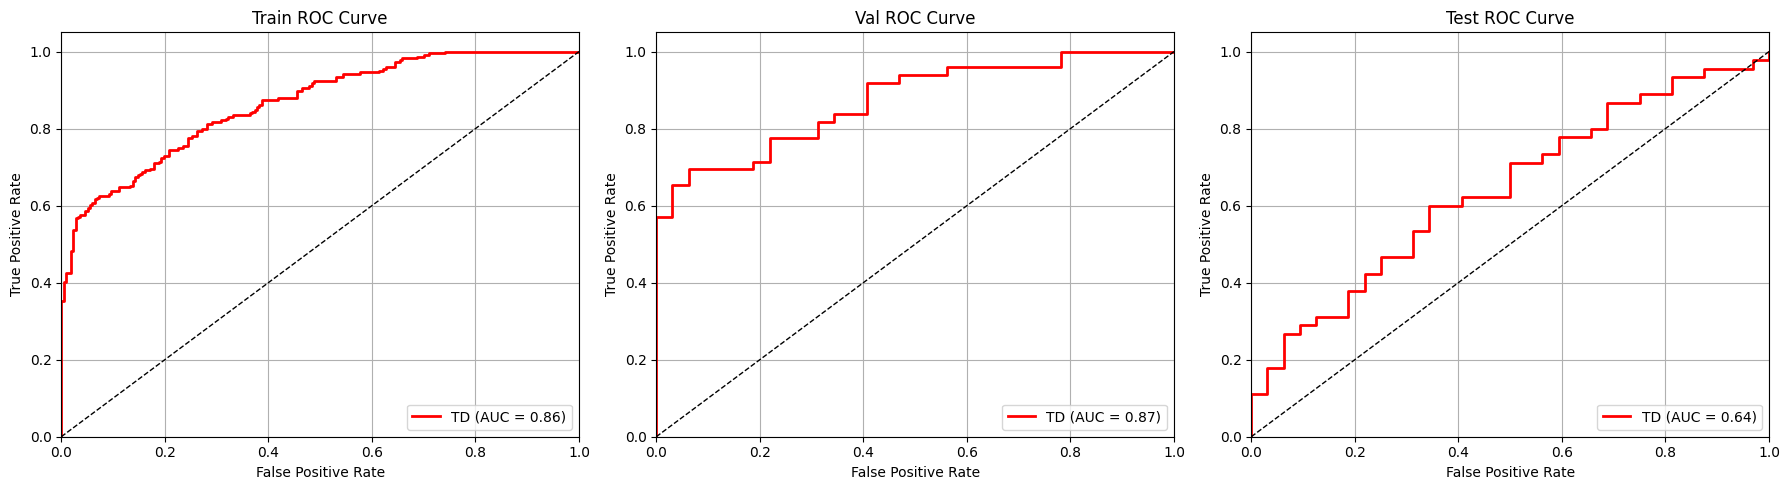

In [35]:
softmax_data = evaluate_model(yaml_file = "saved_models/GAT_Binary_S2_relative.yaml", 
                                model_file = "saved_models/GAT_Binary_S2_relative.pt", 
                                drop_strategy = 2,
                                gat = True)

In [45]:
for d in ['TD']:
    print(f"************ {d} ************")
    epistemic(yaml_file = "saved_models/GAT_Binary_S2_relative.yaml", 
            model_file = "saved_models/GAT_Binary_S2_relative.pt", 
            diagnosis = d,
            dropout = 0.25, 
            forward_passes = 100,
            drop_strategy = 2, 
            gat = True)

************ TD ************
Predicted labels count: {'TD': 49, 'Non-TD': 51}
Mean: 0.4973037838935852
Variance: 0.09688206017017365
